<a href="https://colab.research.google.com/github/PhillipMas/PhillipMas/blob/main/Copy_of_Untitled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikeras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 21.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [2]:
!pip install --upgrade scikit-learn

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training fold 1...
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 247ms/step - loss: 1.2731 - val_loss: 0.5857
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - loss: 1.0339 - val_loss: 0.5833
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 201ms/step - loss: 1.2655 - val_loss: 0.5836
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - loss: 1.1039 - val_loss: 0.5844
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - loss: 1.1327 - val_loss: 0.5853
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step - loss: 1.2012 - val_loss: 0.5880
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - loss: 1.1808 - val_loss: 0.5858
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - loss: 1.0784 - val_loss: 0.5895
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - loss: 1.2054 - val_loss: 0.5861
Epoch 10/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - loss: 1.1568 - val_loss: 0.5877
Epoch 11/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - loss: 1.0883 - val_loss: 0.5894
Epoch 12/10

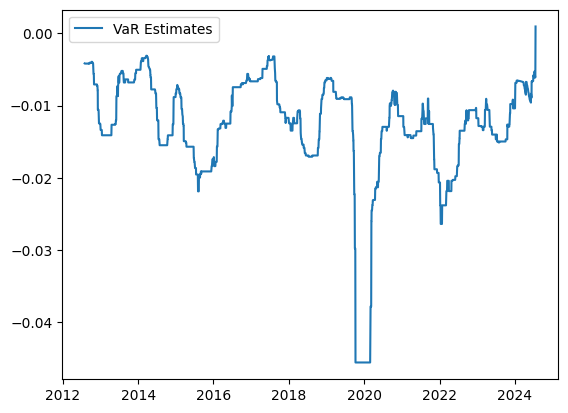

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Fetch data
ticker = '^J203.JO'  # Example ticker
data = yf.download(ticker, start='2012-01-01', end='2024-07-21')
data['Log Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
data = data.dropna()  # Drop NaN values

# Prepare data for LSTM
window_size = 120
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data['Log Returns'].values.reshape(-1, 1))

# Function to create rolling windows
def create_rolling_windows(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create rolling windows
X, y = create_rolling_windows(scaled_data, window_size)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
def create_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(units=100))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize lists to store performance metrics for each fold
mse_scores = []

# K-Fold Cross-Validation
kf = KFold(n_splits=5)
fold = 1
for train_index, val_index in kf.split(X):
    print(f"Training fold {fold}...")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the validation set
    mse = model.evaluate(X_val, y_val, verbose=0)
    mse_scores.append(mse)
    print(f"Fold {fold} MSE: {mse}")

    fold += 1

# Calculate average MSE across all folds
average_mse = np.mean(mse_scores)
print(f"Average MSE across all folds: {average_mse}")

# Train the final model on the entire dataset
final_model = create_model()
final_model.fit(X, y, epochs=100, batch_size=32, verbose=1)

# Predict returns for each rolling window
final_predictions = final_model.predict(X)
final_predictions = scaler.inverse_transform(final_predictions)

# Calculate VaR for each rolling window
final_VaR_estimates = []
for i in range(window_size, len(data)):
    window_predictions = final_predictions[i-window_size:i]
    VaR = np.percentile(window_predictions, 5)  # 5% VaR
    final_VaR_estimates.append(VaR)



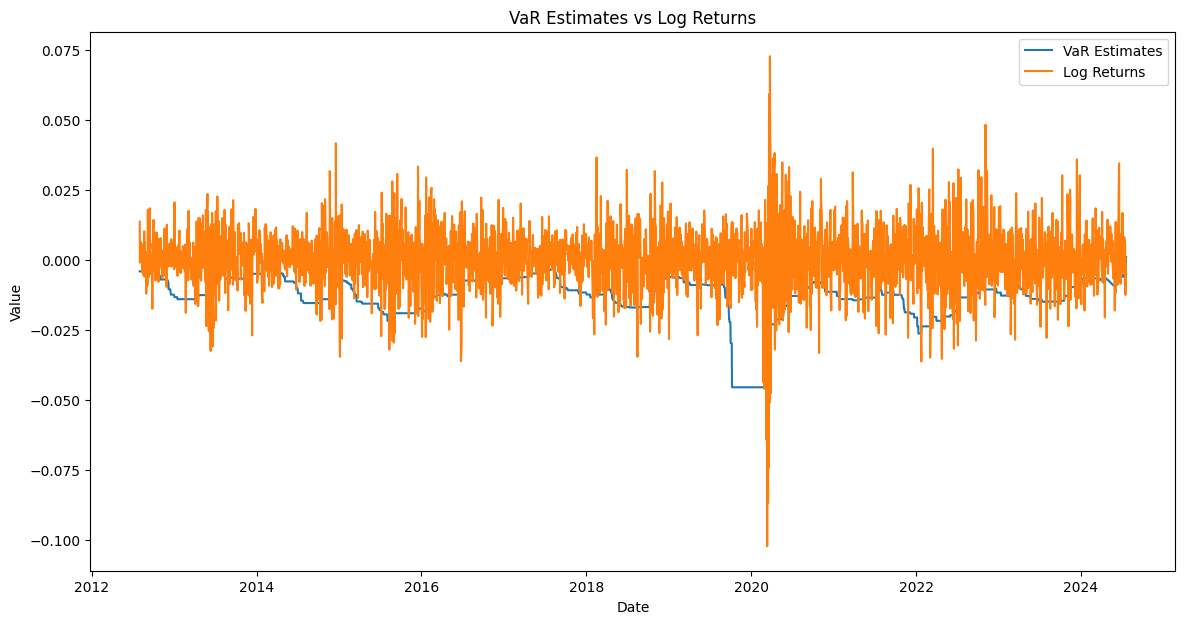

In [4]:
# Plot VaR estimates vs returns
plt.figure(figsize=(14, 7))
# Plot VaR estimates
plt.plot(data.index[window_size:], final_VaR_estimates, label='VaR Estimates')
plt.plot(data.index[window_size:], data['Log Returns'].values[window_size:], label='Log Returns')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('VaR Estimates vs Log Returns')
plt.legend()
plt.show()


In [5]:
final_VaR_estimates

[-0.00416207171510905,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.00416207171510905,
 -0.00416207171510905,
 -0.004184080613777041,
 -0.00416207171510905,
 -0.00416207171510905,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.004184080613777041,
 -0.00416207171510905,
 -0.00416207171510905,
 -0.004049356398172677,
 -0.004049356398172677,
 -0.004049356398172677,
 -0.004049356398172677,
 -0.004049356398172677,
 -0.004049356398172677,
 -0.004049356398172677,